# Dependencies

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('drive/MyDrive/modules')
!nvidia-smi

Fri Feb 11 15:21:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# from here
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import keras
from keras.layers import Dense, Input, GlobalAveragePooling1D, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, Activation, AveragePooling2D, Flatten
# from tensorflow.keras.applications.vgg16 import VGG16
import argparse
from imutils import paths
from sklearn.metrics import recall_score, precision_score, f1_score, \
    accuracy_score, balanced_accuracy_score, ConfusionMatrixDisplay

from aspectawarepreprocessor import AspectAwarePreprocessor
from imagetoarraypreprocessor import ImageToArrayPreprocessor
from simpledatasetloader import SimpleDatasetLoader

from tensorflow.keras.optimizers import Adam,SGD
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras.models import load_model
from keras import backend as K, Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import StratifiedShuffleSplit
import cv2
from sklearn.metrics import classification_report, confusion_matrix
from keras import layers as L
import tensorflow as tf
# from keract import get_activations, display_activations
from matplotlib import pyplot

# Image Process

In [4]:
parent = "/content/drive/MyDrive/Data/train_images/train_images"

labels_train = pd.read_csv("/content/drive/MyDrive/Data/labels_train.csv")

imagePaths = []
for path in labels_train['file_name']:
  wholePath = os.path.join(parent,path)
  imagePaths.append(wholePath)



sp = AspectAwarePreprocessor(224, 224)
iap = ImageToArrayPreprocessor()
sdl = SimpleDatasetLoader(preprocessors=[sp, iap])
X = sdl.load(imagePaths, verbose=500)

Y_train = [l for l in labels_train['class_id']]

X_train, X_val, Y_train, Y_val = train_test_split(X,Y_train,test_size=0.2,shuffle=True)

X_train = X_train.astype('float32') / 255
X_val = X_val.astype('float32') / 255

Y_train = tf.keras.utils.to_categorical(Y_train,num_classes=3)
Y_val = tf.keras.utils.to_categorical(Y_val,num_classes=3)

print(f"[INFO] Found {X_train.shape[0]} images for training with shape:{X_train.shape[1:]}.")
print(f"[INFO] Found {X_val.shape[0]} images for validation with shape:{X_val.shape[1:]}.")

[INFO] processed 500/4672
[INFO] processed 1000/4672
[INFO] processed 1500/4672
[INFO] processed 2000/4672
[INFO] processed 2500/4672
[INFO] processed 3000/4672
[INFO] processed 3500/4672
[INFO] processed 4000/4672
[INFO] processed 4500/4672
[INFO] Found 3737 images for training with shape:(224, 224, 3).
[INFO] Found 935 images for validation with shape:(224, 224, 3).


# Augment Data

In [5]:
datagen  = tf.keras.preprocessing.image.ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.05
)
datagen.fit(X_train)

# Callbacks

In [6]:
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=4, min_lr=0.0000001, verbose=1)


model_weights = 'vgg16_v2-e{epoch:04d}-loss{loss:.3f}-acc{acc:.3f}-valloss{val_loss:.3f}-valacc{val_acc:.3f}.h5'
checkpoint_filepath = os.path.join("/content/drive/MyDrive/Weights",model_weights)

modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    save_best_only=True)

calls = [lr_reducer,modelCheckpoint]

# VGG

In [7]:
print('VGG16 selected')

model_version = "_v5.h5"
model_path = '/content/drive/MyDrive/Saved_Models/vgg16'
model_name = os.path.join(model_path,model_version)

if os.path.isfile(model_name):
  print('Model already trained , loading..')
  model = tf.keras.models.load_model(model_name)
else:
  print("Creating model..")
  base_model = tf.keras.applications.VGG16(weights='imagenet',
                      include_top=False)  # imports the VGG16 model and discards the last 1000 neuron layers.
  # add 3 more layers to the base model
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.2)(x)
  x = Dense(2048, activation='relu')(x)  # we add dense layers so that the model can learn more complex functions and classify for better results.
  x = Dense(1024, activation='relu')(x)  # dense layer 2
  preds = Dense(3, activation='softmax')(x)  # final layer with softmax activation,  ########### -------> for multilabel use sigmoid <-------- ##################
  model = Model(inputs=base_model.input, outputs=preds)
  model.compile(
      optimizer=tf.keras.optimizers.Adam(lr=0.0001, decay=1e-6),
      loss="categorical_crossentropy",
      metrics=['acc']
  )
  model.save(model_name)

model.summary()

VGG16 selected
Creating model..
58900480/58889256 [==============================] - 1s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

# Train

In [8]:
history = model.fit(X_train, Y_train, epochs=5, batch_size=16, verbose=1, validation_data=(X_val,Y_val),callbacks=calls)
model.save(model_name)
print('Saving Trained Model.')

Epoch 1/5
234/234 [==============================] - 131s 481ms/step - loss: 0.7752 - acc: 0.6353 - val_loss: 0.5838 - val_acc: 0.7326 - lr: 1.0000e-04
Epoch 2/5
234/234 [==============================] - 105s 449ms/step - loss: 0.5864 - acc: 0.7436 - val_loss: 0.5021 - val_acc: 0.7936 - lr: 1.0000e-04
Epoch 3/5
234/234 [==============================] - 104s 444ms/step - loss: 0.5128 - acc: 0.7752 - val_loss: 0.5042 - val_acc: 0.7936 - lr: 1.0000e-04
Epoch 4/5
234/234 [==============================] - 105s 448ms/step - loss: 0.4951 - acc: 0.7784 - val_loss: 0.4810 - val_acc: 0.7850 - lr: 1.0000e-04
Epoch 5/5
234/234 [==============================] - 104s 447ms/step - loss: 0.4591 - acc: 0.8047 - val_loss: 0.4713 - val_acc: 0.7882 - lr: 1.0000e-04
Saving Trained Model.


# Plot models

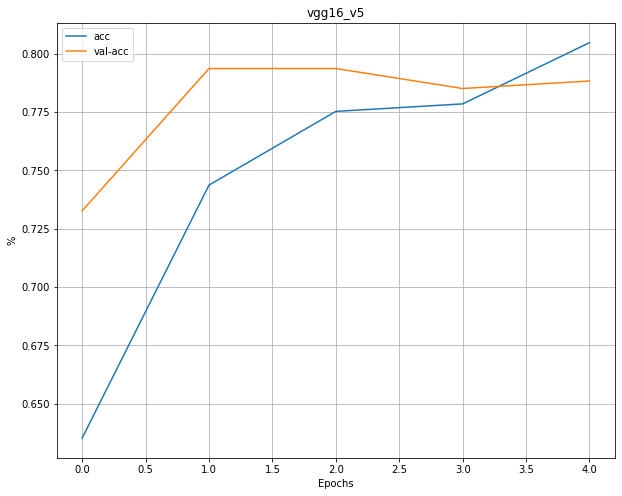

In [11]:
plt.figure(figsize=(10,8))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title("vgg16_v5\")
plt.xlabel('Epochs')
plt.ylabel('%')
plt.legend(('acc','val-acc'))
plt.grid(b=True)

# Evaluate and Predict

In [10]:
scores = model.evaluate(X_val,Y_val)
print(f"Validation Loss :{scores[0]}")
print(f"Validation Accuracy :{scores[1]}")

30/30 [==============================] - 17s 227ms/step - loss: 0.4713 - acc: 0.7882
Validation Loss :0.471331924200058
Validation Accuracy :0.7882353067398071
